<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/Adrian/Fastai_ver1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import cv2
import matplotlib.pyplot as plt
import PIL
print(PIL.__version__)

7.1.2


In [5]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
fastai.__version__

'1.0.61'

In [6]:
import os
import pandas as pd

In [7]:
train_folder = '/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train'
test_folder = '/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/val'
print(os.listdir(train_folder)[:10])
print(os.listdir(test_folder)[:10])

['dog.10.jpg', 'dog.100.jpg', 'dog.0.jpg', 'dog.1.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
['1.jpg', '29.jpg', '53.jpg', '32.jpg', '5.jpg', '25.jpg', '8.jpg', '54.jpg', '9.jpg', '17.jpg']


In [8]:
np.random.seed(2) #Set the random seed to two to guarantee that the same validation set is every time.
fnames = get_image_files(train_folder)
print(fnames[:5])
pat = re.compile(r'(cat|dog)\.\d+\.jpg')

[PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.10.jpg'), PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.100.jpg'), PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.0.jpg'), PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.1.jpg'), PosixPath('/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/dog.101.jpg')]


In [9]:
sz = 64
bs = 64
data = ImageDataBunch.from_name_re(
                                train_folder,
                                fnames,
                                pat,
                                ds_tfms=get_transforms(),
                                size=sz, bs=bs,
                                valid_pct = 0.25,
).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (377 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,dog,dog,dog,dog
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Valid: LabelList (125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,cat,dog,cat,cat
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Test: None

In [10]:
data.classes

['cat', 'dog']

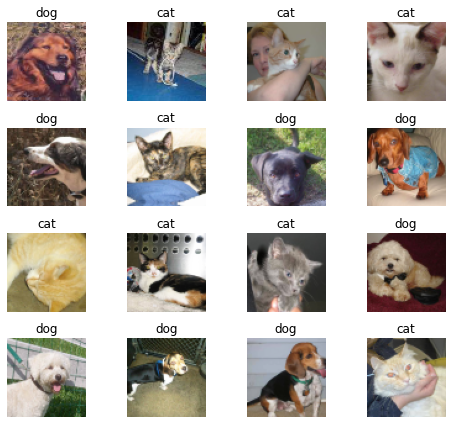

In [11]:
data.show_batch(rows=4, figsize=(7,6))

# Modeling and Training with Resnet34

In [12]:
learn = cnn_learner(
    data,
    models.resnet34,
    metrics=error_rate,
    model_dir="/tmp/model/"
)
# learn.model

In [13]:
learn.data

ImageDataBunch;

Train: LabelList (377 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,dog,dog,dog,dog
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Valid: LabelList (125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,cat,dog,cat,cat
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


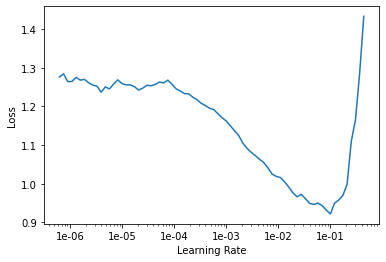

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1) 

epoch,train_loss,valid_loss,error_rate,time
0,1.069959,0.896974,0.208000,00:16


In [17]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4)) #Train for 4 Epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.861221,0.606293,0.216000,00:24
1,0.851828,0.534536,0.208000,00:22
2,0.820506,0.502928,0.192000,00:23
3,0.814252,0.511083,0.192000,00:22


# Results

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
print(len(data.valid_ds)==len(losses)==len(idxs))

True


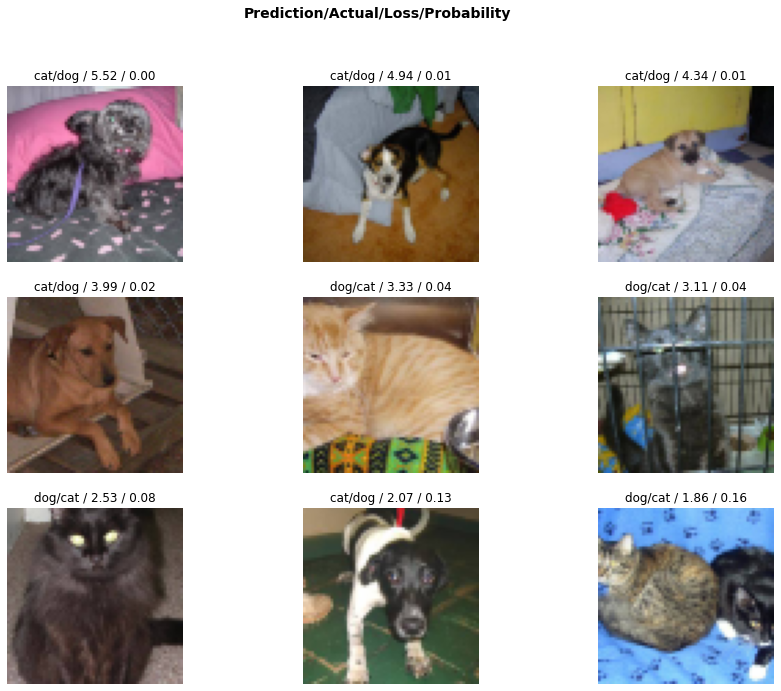

In [19]:
interp.plot_top_losses(9, figsize=(15,11)) # Warum haben die Bilder so eine niedrige Qualität?

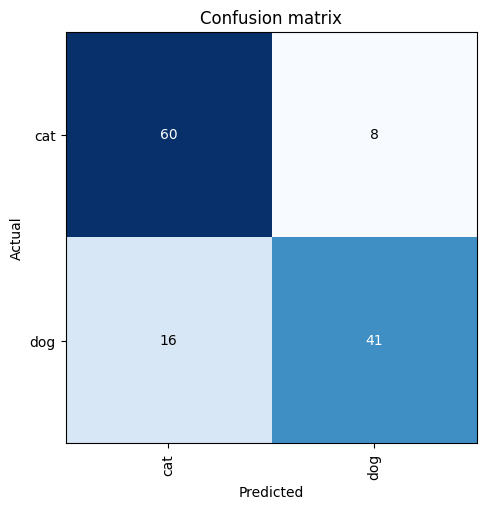

In [20]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [21]:
mc = interp.most_confused(min_val=2)
mcc = [x[0] for x in mc[:5]]
mcc

['dog', 'cat']

In [22]:
train = pd.DataFrame(os.listdir(train_folder))

In [23]:
a = ['0']
train.sample(n=10, random_state=1)

,0
306,cat.15.jpg
342,cat.18.jpg
47,dog.138.jpg
67,dog.159.jpg
376,cat.209.jpg
238,dog.88.jpg
312,cat.150.jpg
31,dog.128.jpg
273,cat.118.jpg
90,dog.18.jpg


# Prepare submission

/content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train/cat.227.jpg


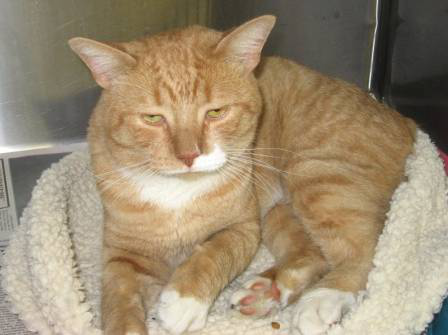

In [26]:
item1_path = data.items[300] # switch number to whatever sample of the dataset to analyse
print(item1_path)
item1 = data.open( item1_path )
item1

In [27]:
pred_class, pred_idx, outputs = learn.predict(item1)
probs = torch.nn.functional.softmax(np.log(outputs), dim=0)
print(pred_class)
print(probs)

cat
tensor([9.9999e-01, 5.2143e-06])


Now the **Test Set**

In [28]:
data_test = ImageList.from_folder(test_folder).split_none().label_empty()
data_test

LabelLists;

Train: LabelList (96 items)
x: ImageList
Image (3, 499, 381),Image (3, 365, 500),Image (3, 499, 438),Image (3, 288, 383),Image (3, 400, 399)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/val;

Valid: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/val;

Test: None

In [29]:
dst = data_test.train.x[:20]
dst

ImageList (20 items)
Image (3, 499, 381),Image (3, 365, 500),Image (3, 499, 438),Image (3, 288, 383),Image (3, 400, 399)
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/val

In [30]:
learn.data

ImageDataBunch;

Train: LabelList (377 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,dog,dog,dog,dog
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Valid: LabelList (125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,cat,dog,cat,cat
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Test: None

In [31]:
data.add_test(items=dst)
data

ImageDataBunch;

Train: LabelList (377 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,dog,dog,dog,dog
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Valid: LabelList (125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,cat,dog,cat,cat
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Test: LabelList (20 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train

In [32]:
learn.data = data
learn.data

ImageDataBunch;

Train: LabelList (377 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,dog,dog,dog,dog
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Valid: LabelList (125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dog,cat,dog,cat,cat
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train;

Test: LabelList (20 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/NN_WS2021/Projekt/Datashort/train

In [33]:
pred_probs, pred_class = learn.get_preds(ds_type=DatasetType.Test)

In [34]:
print(pred_probs)
print(pred_class)
print((pred_probs.numpy()[:,0]>0.5)+0)

tensor([[2.1417e-01, 7.8583e-01],
        [8.2784e-03, 9.9172e-01],
        [9.9852e-01, 1.4780e-03],
        [6.4081e-01, 3.5919e-01],
        [1.0000e+00, 2.6376e-06],
        [9.4511e-01, 5.4890e-02],
        [3.3533e-01, 6.6467e-01],
        [9.9990e-01, 9.9355e-05],
        [9.4611e-01, 5.3894e-02],
        [1.4026e-01, 8.5974e-01],
        [2.9573e-01, 7.0427e-01],
        [7.9074e-01, 2.0926e-01],
        [1.0624e-02, 9.8938e-01],
        [9.9885e-01, 1.1526e-03],
        [7.7892e-04, 9.9922e-01],
        [9.8225e-01, 1.7753e-02],
        [7.7382e-01, 2.2618e-01],
        [1.1017e-02, 9.8898e-01],
        [9.9999e-01, 7.9075e-06],
        [2.7916e-01, 7.2084e-01]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
[0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0]


In [35]:
df = pd.DataFrame(os.listdir(test_folder))
print(len(df))
df.head()

97


,0
0,1.jpg
1,29.jpg
2,53.jpg
3,32.jpg
4,5.jpg


In [37]:
img_idx = 8
print(pred_class[img_idx])
data_test.train.x[img_idx]
plt.imshow(plt.imread(test_folder+df[0].iloc[img_idx]))
# test_folder+df[0]

tensor(0)


FileNotFoundError: ignored

In [ ]:
submission_data = [ids, pred_class]

df = pd.DataFrame(submission_data).T
df.columns = ['id','label']
df.head()

In [ ]:
df.to_csv('./kaggle_catsdogs.csv', index=False)
print( os.path.exists('./kaggle_catsdogs.csv') )

In [ ]:
!rm -rf dogscats